<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b>
    Before proceeding, install or update your
    <b><a class="divlink" href="https://stenv.readthedocs.io/en/latest/">
    stenv
    </a></b>
     distribution. <b>stenv</b> is the replacement for AstroConda, which is unsupported as of February 2023.
</div>

<a id="titleReduction"></a>
# ACS/WFC Image Reduction

## Introduction

***

This notebook covers the steps necessary to calibrate Advanced Camera for Surveys (ACS) Wide Field Channel (WFC) observations to produce a distortion-corrected image ready for photometry.

For most observations, reprocessing the raw files with the calibration pipeline is no longer required as the [MAST](http://archive.stsci.edu) archive is now static and any changes to the pipeline or reference files automatically triggers a reprocessing of the data. However, users may wish to reprocess their data with custom reference files.

This notebook is intended for users with a (very!) basic understanding of python and photometry. 

You will need approximately **13 GB of space** available for this exercise.

### This tutorial will show you how to...

#### 1. [Calibrate Raw Files](#_calibrate) 

* Query the Calibration Reference Data System ([CRDS](https://hst-crds.stsci.edu/)) for the current best reference files applicable to a given observation
* Update the `*_raw.fits` primary headers with new calibration information
* Retrieve calibration files from CRDS and set up the reference file directory
* Process files with `calacs`

#### 2. [Update the WCS](#_wcs) 

* Update the FLT/FLC file WCS header keywords

## Imports
***

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
| `os`             | `environ`          | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.environ">link</a>| setting environments |
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`glob`            | `glob`             | <a class="divlink" href="https://docs.python.org/2/library/glob.html#glob.glob">link</a>| search for files based on Unix shell rules |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`astropy.table`   | `Table`            | <a class="divlink" href="http://docs.astropy.org/en/stable/table/">link</a>| constructing and editing in a tabular format |
|`stwcs`           |`updatewcs`         | <a class="divlink" href="https://stwcs.readthedocs.io/en/latest/updatewcs_ui.html">link</a>| update wcs solution |

In [1]:
import os
import shutil
import glob

from astroquery.mast import Observations

from astropy.io import fits

from stwcs import updatewcs

from p_module import plot

## Download the Data <a id="_download"></a>
***

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

#### [GO Proposal 10775](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=10775): "An ACS Survey of Galactic Globular Clusters"

For this example, we will only retreive data associated with the Observation ID **J9L960010**. Using the python package `astroquery`, we can access the [MAST](http://archive.stsci.edu) archive. 

We will need to grab the raw files, the telemetry files, and the association file for this observation set.

<div class="alert alert-danger">
<b>MAY CHANGE:</b> The argument "mrp_only" stands for "minimum recommended products only". It currently needs to be set to False, although in the future, False is intended to be set as the default and can be left out.
</div>

In [2]:
obs_table = Observations.query_criteria(proposal_id=10775, obs_id='J9L960010')


dl_table = Observations.download_products(obs_table['obsid'],
                                          productSubGroupDescription=['RAW', 'ASN', 'SPT'],
                                          mrp_only=False)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


We'll use the packages `os` and `shutil` to put all of these files in our working directory and do a little housekeeping.

In [3]:
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

Here we set our filenames to variable names for convenience using `glob.glob`.

In [4]:
asn_file = 'j9l960010_asn.fits'
raw_files = glob.glob('*_raw.fits')

## File Information
***
The structure of the fits files from ACS may be different depending on what kind of observation was made. For more information, refer to Section 2.2 of the [ACS Data Handbook](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

### Association Files

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| ASN (Association)| (BinTableHDU)| Table of files associated with this group.             |

### Raw Files (WFC-Specific)

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| SCI (Image)      | (ImageHDU)   | WFC2 raw image data.                                   |
|<b>2</b>| ERR (Error)      | (ImageHDU)   | WFC2 error array.                                      |
|<b>3</b>| DQ (Data Quality)| (ImageHDU)   | WFC2 data quality array.                               |
|<b>4</b>| SCI (Image)      | (ImageHDU)   | WFC1 raw image data.                                   |
|<b>5</b>| ERR (Error)      | (ImageHDU)   | WFC1 error array.                                      |
|<b>6</b>| DQ (Data Quality)| (ImageHDU)   | WFC1 data quality array.                               |

You can always use `.info()` on an HDUlist for an overview of the structure

In [5]:
with fits.open(asn_file) as hdulist:
    hdulist.info()
    
with fits.open(raw_files[0]) as hdulist:
    hdulist.info()

Filename: j9l960010_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  ASN           1 BinTableHDU     25   6R x 3C   [14A, 14A, L]   


Filename: j9l960a7q_raw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     222   ()      
  1  SCI           1 ImageHDU        97   (4144, 2068)   int16 (rescales to uint16)   
  2  ERR           1 ImageHDU        49   ()      
  3  DQ            1 ImageHDU        41   ()      
  4  SCI           2 ImageHDU        97   (4144, 2068)   int16 (rescales to uint16)   
  5  ERR           2 ImageHDU        49   ()      
  6  DQ            2 ImageHDU        43   ()      


In [6]:
!conda list hstcal

# packages in environment at /usr/share/miniconda/envs/hstcal:
#
# Name                    Version                   Build  Channel
hstcal                    3.0.3                hc213fb8_0    conda-forge


## Calibrate Raw Files <a id="_calibrate"></a>

***

Now that we have the `*_raw.fits` files, we can process them with the ACS calibration pipeline `calacs`. 

#### Updating Headers for CRDS

By default, the association file will trigger the creation of a drizzled product. In order to avoid this, we will filter the association file to only include table entries with `MEMTYPE` equal to 'EXP-DTH'. This will remove the 'PROD-DTH' entry that prompts AstroDrizzle.

In [7]:
with fits.open(asn_file, mode='update') as asn_hdu:
    asn_tab = asn_hdu[1].data
    asn_tab = asn_tab[asn_tab['MEMTYPE'] == 'EXP-DTH']

Due to the computationally intense processing required to CTE correct full-frame ACS/WFC images, we have disabled the CTE correction here by default, however it can be turned on by changing the following variable to True:

In [8]:
cte_correct = False

Calibration steps can be enabled or disabled by setting the switch keywords in the primary header to 'PERFORM' or 'OMIT', respectively. Switch keywords  all end with the string `CORR` (e.g., `BLEVCORR` and `DARKCORR`). In this case, we want to update `PCTECORR`.

In [9]:
for file in raw_files:
    
    if cte_correct: 
        value = 'PERFORM'
    else: 
        value = 'OMIT'
        
    fits.setval(file, 'PCTECORR', value=value)

#### Querying CRDS for Reference Files

Before running `calacs`, we need to set some environment variables for several subsequent calibration tasks.

We will point to a subdirectory called `crds_cache/` using the JREF environment variable. The `JREF` variable is used for ACS reference files. Other instruments use other variables, e.g., `IREF` for WFC3.

In [10]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['jref'] = './crds_cache/references/hst/acs/'

The code block below will query CRDS for the best reference files currently available for these datasets, update the header keywords to point "to these new files. We will use the Python package `os` to run terminal commands. In the terminal, the line would be:

    crds bestrefs --files [filename] --sync-references=1 --update-bestrefs
    
...where 'filename' is the name of your fits file.

In [11]:
for file in raw_files:
    command_line_input = 'crds bestrefs --files {:} --sync-references=1 --update-bestrefs'.format(file)
    os.system(command_line_input)

CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap       678 bytes  (1 / 142 files) (0 / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap       977 bytes  (2 / 142 files) (678 / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap         642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap       685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap         696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap    30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap       801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_darkfile_0250.rmap   178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_biasfile_0250.rmap     3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_atodfile_0250.rmap       874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_0250.imap                782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_snkcfile_0003.rmap        681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_satufile_0002.rmap      1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pfltfile_0253.rmap     34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pctetab_0004.rmap         698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_oscntab_0250.rmap         747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_npolfile_0254.rmap      4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_nlinfile_0250.rmap        726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_mdriztab_0254.rmap        845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_imphttab_0256.rmap        683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_idctab_0254.rmap          661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_flshfile_0256.rmap      5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_drkcfile_0194.rmap    234.8 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_dfltfile_0002.rmap     17.1 K bytes  (24 / 142 files) (502.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_darkfile_0492.rmap    276.0 K bytes  (25 / 142 files) (519.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_d2imfile_0251.rmap        605 bytes  (26 / 142 files) (795.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_crrejtab_0250.rmap        803 bytes  (27 / 142 files) (796.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_ccdtab_0250.rmap          799 bytes  (28 / 142 files) (797.2 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_bpixtab_0310.rmap      11.7 K bytes  (29 / 142 files) (798.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biasfile_0267.rmap     23.4 K bytes  (30 / 142 files) (809.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biacfile_0003.rmap        692 bytes  (31 / 142 files) (833.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_atodtab_0250.rmap         651 bytes  (32 / 142 files) (833.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_0595.imap               1.3 K bytes  (33 / 142 files) (834.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmttab_0002.rmap       745 bytes  (34 / 142 files) (835.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmgtab_0012.rmap       767 bytes  (35 / 142 files) (836.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmctab_0052.rmap       743 bytes  (36 / 142 files) (837.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thruput_0056.rmap  329.6 K bytes  (37 / 142 files) (837.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_0067.imap              579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_xtractab_0250.rmap        815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_wcptab_0251.rmap          578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_teltab_0250.rmap          745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdstab_0254.rmap          921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdctab_0252.rmap          650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_srwtab_0250.rmap          745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sptrctab_0251.rmap        895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sdctab_0251.rmap          889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_riptab_0254.rmap          877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_phottab_0258.rmap       1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pfltfile_0250.rmap     23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pctab_0250.rmap         3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mofftab_0250.rmap         747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mlintab_0250.rmap         601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lfltfile_0250.rmap     11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lamptab_0250.rmap         610 bytes  (56 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_inangtab_0250.rmap        815 bytes  (57 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_imphttab_0252.rmap        616 bytes  (58 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_idctab_0251.rmap          775 bytes  (59 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_halotab_0250.rmap         747 bytes  (60 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_gactab_0250.rmap          651 bytes  (61 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_exstab_0250.rmap          745 bytes  (62 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap        749 bytes  (63 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_disptab_0250.rmap         813 bytes  (64 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_darkfile_0353.rmap     59.7 K bytes  (65 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap        711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap          745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap          893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_bpixtab_0250.rmap         845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_biasfile_0355.rmap    119.5 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apertab_0250.rmap         588 bytes  (71 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apdestab_0252.rmap        636 bytes  (72 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_0369.imap               1.7 K bytes  (73 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tdffile_0250.rmap     8.9 K bytes  (76 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_phottab_0250.rmap       862 bytes  (82 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_idctab_0250.rmap        767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_0250.imap             1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_ywlkfile_0003.rmap         922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xwlkfile_0002.rmap         922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xtractab_0269.rmap       1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_wcptab_0257.rmap         1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_twozxtab_0277.rmap         990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tracetab_0276.rmap         998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tdstab_0271.rmap           803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spwcstab_0255.rmap       1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spottab_0006.rmap          766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_proftab_0276.rmap        1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_phatab_0250.rmap           668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_lamptab_0264.rmap        1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvtab_0259.rmap            567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvdstab_0002.rmap        1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_gsagtab_0259.rmap          712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_geofile_0250.rmap          670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_fluxtab_0282.rmap        1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_flatfile_0264.rmap       1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_disptab_0276.rmap        1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_dgeofile_0002.rmap         909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_deadtab_0250.rmap          711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brsttab_0250.rmap          696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brftab_0250.rmap           614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_bpixtab_0260.rmap          773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_badttab_0252.rmap          643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_0357.imap                1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_spottab_0251.rmap          641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_snkcfile_0097.rmap       7.3 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap         531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_satufile_0002.rmap       1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap      69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap          615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap          781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap       3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap          646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap         769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_imphttab_0260.rmap         769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_idctab_0256.rmap         1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_flshfile_0268.rmap       3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_drkcfile_0448.rmap      14.8 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_dgeofile_0250.rmap       3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_darkfile_0439.rmap      86.8 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_d2imfile_0253.rmap         601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_crrejtab_0251.rmap         945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_cfltfile_0250.rmap       1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_ccdtab_0256.rmap         1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_bpixtab_0252.rmap        1.0 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_biasfile_0437.rmap      56.9 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_atodtab_0251.rmap          528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_0538.imap                1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_1177.pmap                      495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing j9l960a7q_raw.fits


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/17717071j_osc.fits        17.3 K bytes  (1 / 13 files) (0 / 915.2 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/25g1256nj_bpx.fits        23.0 K bytes  (2 / 13 files) (17.3 K / 915.2 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/37g1550cj_mdz.fits       247.7 K bytes  (3 / 13 files) (40.3 K / 915.2 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4af1559ij_imp.fits       953.3 K bytes  (4 / 13 files) (288.0 K / 915.2 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4bb1536ej_npl.fits        51.8 K bytes  (5 / 13 files) (1.2 M / 915.2 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4bb1536oj_idc.fits       285.1 K bytes  (6 / 13 files) (1.3 M / 915.2 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4bb15371j_d2i.fits        51.8 K bytes  (7 / 13 files) (1.6 M / 915.2 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/5331917aj_sat.fits       171.4 M bytes  (8 / 13 files) (1.6 M / 915.2 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/66318264j_bia.fits       171.5 M bytes  (9 / 13 files) (173.1 M / 915.2 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/72m1821ij_ccd.fits        43.2 K bytes  (10 / 13 files) (344.5 M / 915.2 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/78f1759jj_drk.fits       268.5 M bytes  (11 / 13 files) (344.6 M / 915.2 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/nar1136pj_pfl.fits       167.8 M bytes  (12 / 13 files) (613.1 M / 915.2 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/qbu16424j_dxy.fits       134.3 M bytes  (13 / 13 files) (780.9 M / 915.2 M bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  157 infos


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j9l960abq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j9l960adq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j9l960a9q_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j9l960afq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


#### Running calacs

Finally, we can run `calacs` on the association file. It will produce `*_flt.fits`. The FLT files have had the default CCD calibration steps (bias subtraction, dark subtraction, flat field normalization) performed.

<div class="alert alert-block alert-info"><b>If the CTE correction is enabled...</b>

   * ...this next step will take a long time to complete. The CTE correction is computationally expensive and will use all of the cores on a machine by default. On an 8 core machine, CTE correcting a full-frame ACS/WFC image can take approximately 15 minutes per RAW file. 
   

   * ...`*_flc.fits` will also be produced.  The FLC files are CTE-corrected but otherwise identical to the FLT files.
</div>

In [12]:
os.system('calacs.e j9l960010_asn.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Setting max threads to 4 out of 4 available


CALBEG*** CALACS -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:31 UTC


Input    j9l960010_asn.fits
LoadAsn:  Processing FULL Association
Trying to open j9l960010_asn.fits...
Read in Primary header from j9l960010_asn.fits...


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:31 UTC
Input    j9l960a7q_raw.fits
Output   j9l960a7q_blv_tmp.fits
Trying to open j9l960a7q_raw.fits...
Read in Primary header from j9l960a7q_raw.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PER

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =5.33,4.99,5.51,5.16
    gain =2.002,1.945,2.028,1.994
   default bias levels =4535.7,4535.7,4590.2,4498.9


SINKCORR OMIT




End      29-Aug-2024 17:12:32 UTC


*** ACSCCD complete ***


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:32 UTC
Input    j9l960a7q_blv_tmp.fits
Output   j9l960a7q_flt.fits
Trying to open j9l960a7q_blv_tmp.fits...
Read in Primary header from j9l960a7q_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 17:12:32 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f1759jj_drk.fits
DARKFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
DARKFILE DESCRIP =Standard full-frame dark for data taken after Mar 04 2006 08:00:00-
Darktime from header 6.207202
Mean of dark image (MEANDARK) = 0.0387592
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
PFLTFILE jref$nar1136pj_pfl.fits
PFLTFILE PEDIGREE=InFlight 18/04/2002 - 09/05/2002
PFLTFILE DESCRIP =F606W step +1 flat w/ mote shifted to  0 step


FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0711 as parnames[0]
==> Value of PHOTFLAM = 7.7916653e-20
==> Value of PHOTPLAM = 5919.7118
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 17:12:32 UTC


Imset 2  Begin 17:12:32 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 6.207202


Mean of dark image (MEANDARK) = 0.0417828
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0711 as parnames[0]
==> Value of PHOTFLAM = 7.7916653e-20
==> Value of PHOTPLAM = 5919.7118
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 17:12:32 UTC


End      29-Aug-2024 17:12:32 UTC


*** ACS2D complete ***


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:32 UTC
Input    j9l960a9q_raw.fits
Output   j9l960a9q_blv_tmp.fits
Trying to open j9l960a9q_raw.fits...
Read in Primary header from j9l960a9q_raw.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PERFORM
BIASFILE jref$66318264j_bia.fits
BIASFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
BIASFILE DESCRIP =Standard full-frame bias for data taken after Mar 04 2006 08:00:00-
BIASCORR COMPLETE


BLEVCORR PERFORM
OSCNTAB  jref$17717071j_osc.fits
OSCNTAB  PEDIGREE=GROUND
OSCNTAB  DESCRIP =New O

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


Full-well saturation flagging being performed for imset 2.

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =5.33,4.99,5.51,5.16
    gain =2.002,1.945,2.028,1.994
   default bias levels =4535.7,4535.7,4590.2,4498.9


SINKCORR OMIT




End      29-Aug-2024 17:12:33 UTC


*** ACSCCD complete ***


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:33 UTC
Input    j9l960a9q_blv_tmp.fits
Output   j9l960a9q_flt.fits
Trying to open j9l960a9q_blv_tmp.fits...
Read in Primary header from j9l960a9q_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 17:12:33 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f1759jj_drk.fits
DARKFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
DARKFILE DESCRIP =Standard full-frame dark for data taken after Mar 04 2006 08:00:00-
Darktime from header 53.111202
Mean of dark image (MEANDARK) = 0.331638
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
PFLTFILE jref$nar1136pj_pfl.fits
PFLTFILE PEDIGREE=InFlight 18/04/2002 - 09/05/2002
PFLTFILE DESCRIP =F606W step +1 flat w/ mote shifted to  0 step


FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0777 as parnames[0]
==> Value of PHOTFLAM = 7.7916655e-20
==> Value of PHOTPLAM = 5919.7118
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 17:12:33 UTC


Imset 2  Begin 17:12:33 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 53.111202


Mean of dark image (MEANDARK) = 0.35751
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0777 as parnames[0]
==> Value of PHOTFLAM = 7.7916655e-20
==> Value of PHOTPLAM = 5919.7118
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 17:12:34 UTC


End      29-Aug-2024 17:12:34 UTC


*** ACS2D complete ***


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:34 UTC
Input    j9l960abq_raw.fits
Output   j9l960abq_blv_tmp.fits
Trying to open j9l960abq_raw.fits...
Read in Primary header from j9l960abq_raw.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PERFORM
BIASFILE jref$66318264j_bia.fits
BIASFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
BIASFILE DESCRIP =Standard full-frame bias for data taken after Mar 04 2006 08:00:00-
BIASCORR COMPLETE


BLEVCORR PERFORM
OSCNTAB  jref$17717071j_osc.fits
OSCNTAB  PEDIGREE=GROUND
OSCNTAB  DESCRIP =New O

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


Full-well saturation flagging being performed for imset 2.

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =5.33,4.99,5.51,5.16
    gain =2.002,1.945,2.028,1.994
   default bias levels =4535.7,4535.7,4590.2,4498.9


SINKCORR OMIT




End      29-Aug-2024 17:12:34 UTC


*** ACSCCD complete ***


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:34 UTC
Input    j9l960abq_blv_tmp.fits
Output   j9l960abq_flt.fits
Trying to open j9l960abq_blv_tmp.fits...
Read in Primary header from j9l960abq_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 17:12:34 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f1759jj_drk.fits
DARKFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
DARKFILE DESCRIP =Standard full-frame dark for data taken after Mar 04 2006 08:00:00-
Darktime from header 53.215202
Mean of dark image (MEANDARK) = 0.332288
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
PFLTFILE jref$nar1136pj_pfl.fits
PFLTFILE PEDIGREE=InFlight 18/04/2002 - 09/05/2002
PFLTFILE DESCRIP =F606W step +1 flat w/ mote shifted to  0 step


FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0852 as parnames[0]
==> Value of PHOTFLAM = 7.7916658e-20
==> Value of PHOTPLAM = 5919.7118
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 17:12:35 UTC


Imset 2  Begin 17:12:35 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 53.215202


Mean of dark image (MEANDARK) = 0.35821
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0852 as parnames[0]
==> Value of PHOTFLAM = 7.7916658e-20
==> Value of PHOTPLAM = 5919.7118
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 17:12:35 UTC


End      29-Aug-2024 17:12:35 UTC


*** ACS2D complete ***


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:35 UTC
Input    j9l960adq_raw.fits
Output   j9l960adq_blv_tmp.fits
Trying to open j9l960adq_raw.fits...
Read in Primary header from j9l960adq_raw.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PERFORM
BIASFILE jref$66318264j_bia.fits
BIASFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
BIASFILE DESCRIP =Standard full-frame bias for data taken after Mar 04 2006 08:00:00-
BIASCORR COMPLETE


BLEVCORR PERFORM
OSCNTAB  jref$17717071j_osc.fits
OSCNTAB  PEDIGREE=GROUND
OSCNTAB  DESCRIP =New O

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


Full-well saturation flagging being performed for imset 2.

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =5.33,4.99,5.51,5.16
    gain =2.002,1.945,2.028,1.994
   default bias levels =4535.7,4535.7,4590.2,4498.9


SINKCORR OMIT




End      29-Aug-2024 17:12:35 UTC


*** ACSCCD complete ***


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:35 UTC
Input    j9l960adq_blv_tmp.fits
Output   j9l960adq_flt.fits
Trying to open j9l960adq_blv_tmp.fits...
Read in Primary header from j9l960adq_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 17:12:35 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f1759jj_drk.fits
DARKFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
DARKFILE DESCRIP =Standard full-frame dark for data taken after Mar 04 2006 08:00:00-
Darktime from header 53.111202
Mean of dark image (MEANDARK) = 0.331638
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
PFLTFILE jref$nar1136pj_pfl.fits
PFLTFILE PEDIGREE=InFlight 18/04/2002 - 09/05/2002
PFLTFILE DESCRIP =F606W step +1 flat w/ mote shifted to  0 step


FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0927 as parnames[0]
==> Value of PHOTFLAM = 7.7916661e-20
==> Value of PHOTPLAM = 5919.7117
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 17:12:36 UTC


Imset 2  Begin 17:12:36 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 53.111202


Mean of dark image (MEANDARK) = 0.35751
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.0927 as parnames[0]
==> Value of PHOTFLAM = 7.7916661e-20
==> Value of PHOTPLAM = 5919.7117
==> Value of PHOTBW = 672.44856
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 17:12:36 UTC


End      29-Aug-2024 17:12:36 UTC


*** ACS2D complete ***


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:36 UTC
Input    j9l960afq_raw.fits
Output   j9l960afq_blv_tmp.fits
Trying to open j9l960afq_raw.fits...
Read in Primary header from j9l960afq_raw.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PERFORM
BIASFILE jref$66318264j_bia.fits
BIASFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
BIASFILE DESCRIP =Standard full-frame bias for data taken after Mar 04 2006 08:00:00-
BIASCORR COMPLETE


BLEVCORR PERFORM
OSCNTAB  jref$17717071j_osc.fits
OSCNTAB  PEDIGREE=GROUND
OSCNTAB  DESCRIP =New O

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


Full-well saturation flagging being performed for imset 2.

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =5.33,4.99,5.51,5.16
    gain =2.002,1.945,2.028,1.994
   default bias levels =4535.7,4535.7,4590.2,4498.9


SINKCORR OMIT




End      29-Aug-2024 17:12:37 UTC


*** ACSCCD complete ***


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:37 UTC
Input    j9l960afq_blv_tmp.fits
Output   j9l960afq_flt.fits
Trying to open j9l960afq_blv_tmp.fits...
Read in Primary header from j9l960afq_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 17:12:37 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f1759jj_drk.fits
DARKFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
DARKFILE DESCRIP =Standard full-frame dark for data taken after Mar 04 2006 08:00:00-
Darktime from header 53.247204
Mean of dark image (MEANDARK) = 0.332488
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
PFLTFILE jref$nar1136pj_pfl.fits
PFLTFILE PEDIGREE=InFlight 18/04/2002 - 09/05/2002
PFLTFILE DESCRIP =F606W step +1 flat w/ mote shifted to  0 step


FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.1387 as parnames[0]
==> Value of PHOTFLAM = 7.791668e-20
==> Value of PHOTPLAM = 5919.7117
==> Value of PHOTBW = 672.44855
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 17:12:37 UTC


Imset 2  Begin 17:12:37 UTC


CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 53.247204


Mean of dark image (MEANDARK) = 0.358425
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#53807.1387 as parnames[0]
==> Value of PHOTFLAM = 7.791668e-20
==> Value of PHOTPLAM = 5919.7117
==> Value of PHOTBW = 672.44855
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 17:12:37 UTC


End      29-Aug-2024 17:12:37 UTC


*** ACS2D complete ***
Finished CCD processing...


CALBEG*** ACSDTH -- Version 10.3.5 (08-Feb-2022) ***
Begin    29-Aug-2024 17:12:37 UTC
The task PyDrizzle needs to be run in order to generate
a geometrically corrected, drizzle-combined product.
PyDrizzle requires PyRAF. See pyraf.stsci.edu for more details.
Warning    Output file `j9l960010_spt.fits' already exists.
ERROR:    CALACS processing NOT completed for j9l960010_asn.fits
ERROR:    CALACS processing NOT completed for j9l960010_asn.fits
ERROR:             status = 1021


512

Selecting an image to plot, depending on whether or not you enabled CTE correction earlier.

In [13]:
if cte_correct:
    fl_fits = 'j9l960a7q_flc.fits'
else:
    fl_fits = 'j9l960a7q_flt.fits'

#### Plotting results

As a check of our calibrated products, we will plot a subsection of one of the input images.

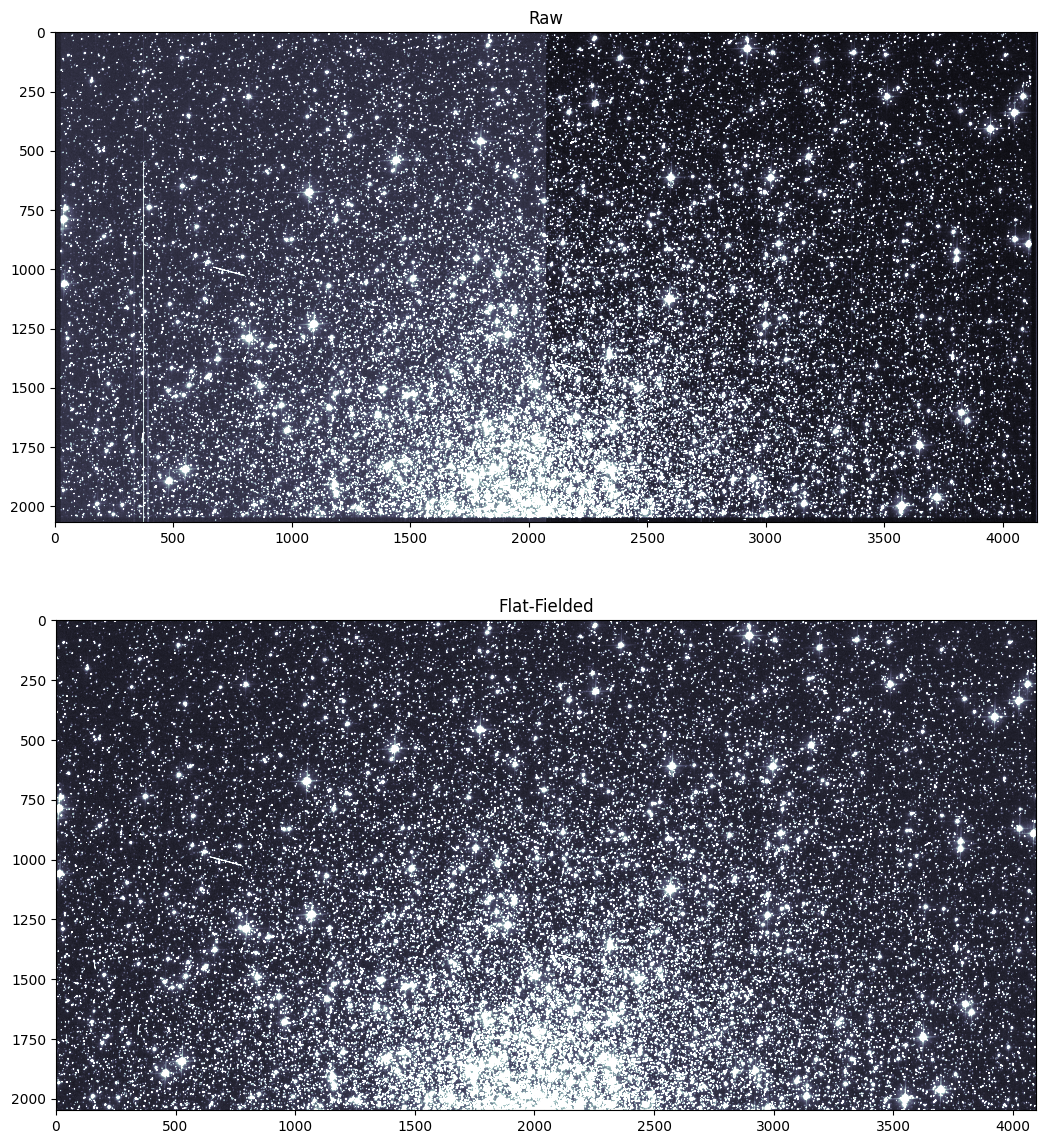

In [14]:
raw_image = fits.getdata('j9l960a7q_raw.fits')
cal_image = fits.getdata(fl_fits)

plot.calib_compare_plot(raw_image, cal_image)

Comparing the FLT calibrated image to the RAW uncalibrated one, we can see that image artifacts have been removed. Most noticeably, hot columns in the bias have been subtracted.

In [15]:
if cte_correct:
    img_files = 'j9l9*a[9-f]q_flc.fits'
else:
    img_files = 'j9l9*a[9-f]q_flt.fits'

updatewcs.updatewcs(img_files, use_db=False)

Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...


- IDCTAB: Distortion model from row 443 for chip 1 : F606W


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


['j9l960afq_flt.fits',
 'j9l960a9q_flt.fits',
 'j9l960adq_flt.fits',
 'j9l960abq_flt.fits']

## Conclusion

***

The FLT and FLC images are not yet suitable for photometry. Before performing any analysis on the images, we still need to remove detector artifacts, cosmic rays, and geometric distortion. [AstroDrizzle](http://www.stsci.edu/scientific-community/software/drizzlepac.html) can do all of these steps and produce a single mosaic image that incorporates all of the individual exposures.

Users who do not use `astrodrizzle` to correct data for distortion will need to apply a pixel area map to their data to correct for the distorted pixel area projected onto the sky before performing photometry. For those who would like to learn how to create a pixel area map, a Jupyter Notebook on the subject can be found [here](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/ACS/acs_pixel_area_maps/acs_pixel_area_maps.ipynb).

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.

---
[Top of Page](#titleReduction)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
<br></br>
<br></br>